In [51]:
import numpy as np
from matplotlib import pyplot as plt
import cv2

In [52]:
# MOB subtractor
subtractor = cv2.createBackgroundSubtractorMOG2(detectShadows=False)

In [53]:
# kp and des methods

sift = cv2.xfeatures2d.SIFT_create()
def siftKpAndDes(frame):
    return sift.detectAndCompute(frame,None)

surf = cv2.xfeatures2d.SURF_create()
def surfKpAndDes(frame):
    return surf.detectAndCompute(frame,None)

star = cv2.xfeatures2d.StarDetector_create()
def fastKp(frame):
    return star.detect(frame,None)

brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()
def briefDes(frame, kps):
    return brief.compute(frame, kps)

orb = cv2.ORB_create()
def orbKpAndDes(frame):
    return orb.detectAndCompute(frame,None)

In [54]:
# matcher methods

FLANN_INDEX_KDTREE = 1
FLANN_KDTREES = 5

FLANN_INDEX_LSH = 6
TABLE_NUMBER = 6 #12
KEY_SIZE = 12 #20
MULTI_PROBE_LEVEL = 1 #2
SEARCH_CHECKS = 50

#BF matching
bf_orb = cv2.BFMatcher(cv2.NORM_HAMMING)
bf_sift = cv2.BFMatcher()
def bfMatcher(des1, des2, feature_type = 'SIFT', ratio = 0.7):

    if feature_type is 'ORB': 
        matches = bf_orb.knnMatch(des1,des2,k=2)
    else:
        matches = bf_sift.knnMatch(des1, des2, k=2)
    # filter using ratio
    good = []
    for pair in matches:
        try:
            m,n = pair
            if m.distance < ratio*n.distance:
                good.append(m)
        except ValueError:
            print('Missing Match pair!')
            passq
    return good, matches


#FLANN-based
search_params = dict(checks = SEARCH_CHECKS)
flann_orb = cv2.FlannBasedMatcher(dict(algorithm = FLANN_INDEX_LSH,
                   table_number = TABLE_NUMBER,
                   key_size = KEY_SIZE,
                   multi_probe_level = MULTI_PROBE_LEVEL),
                   search_params)
flann_sift = cv2.FlannBasedMatcher(dict(algorithm = FLANN_INDEX_KDTREE, trees = FLANN_KDTREES), 
                                   search_params )
def flannMatcher(des1, des2, feature_type = 'SIFT', ratio=0.7):
    
    if feature_type is 'ORB': 
        matches = flann_orb.knnMatch(des1, des2, k=2)
    else:
        matches = flann_sift.knnMatch(des1, des2, k=2)
    # filter using ratio
    good = []
    for pair in matches:
        try:
            m,n = pair
            if m.distance < ratio*n.distance:
                good.append(m)
        except ValueError:
            print('Missing Match pair!')
            pass
    return good, matches
        

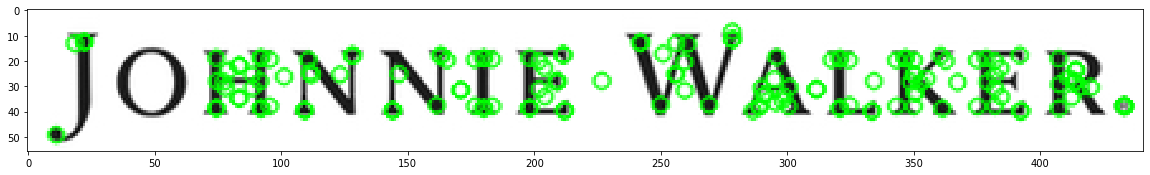

151


In [110]:
# preprocess kp/des for query image(s)

img1 = cv2.imread('logos/walker_text.jpg',0)          # queryImage
# find the keypoints and descriptors
kp1, des1 = siftKpAndDes(img1)

img1kps = cv2.drawKeypoints(img1, kp1, None, color=(0,255,0), flags=0)
plt.figure(figsize=(20,20))
plt.imshow(img1kps), plt.show()

print(len(kp1))

In [111]:
FRAME_INTERVAL = 1
MIN_MATCH_COUNT =  15 #RULE: >10% of keypoints in query image? -> work well only fort scale-invarient (SIFT)
LOWE_RATIO = 0.7 #lowered from 0.7 to derease sensitivity

cap = cv2.VideoCapture('videos/15brazil-5min.mp4')

while(True):
    for i in range(FRAME_INTERVAL):
        #skip i number of frames
        cap.grab()
        
    # Capture frame-by-frame and covert to grayscale
    ret, frame = cap.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
#     # TESTING: MOG2 background subtractor mask
#     mask = subtractor.apply(gray, masked, 0.999)
#     masked = cv2.bitwise_and(gray, masked)
#     kp2, des2 = siftKpAndDes(masked)


#     # TESTING: Equalize historgram to incrase contrast (probably for ORB)
#     eh = cv2.equalizeHist(gray)
#     kp2, des2 = siftKpAndDes(eh)

#     # TESTING: Blurring with various LPFs
#     blurred = cv2.bilateralFilter(gray,9,75,75)
#     kp2, des2 = siftKpAndDes(blurred)
            
    # DEFAULT: find the keypoints and descriptors
    kp2, des2 = siftKpAndDes(gray)
    
#     # DEBUGGING: show only target image kps
#     img3 = cv2.drawKeypoints(blurred, kp2, None, color=(0,255,0), flags=0)
#     cv2.imshow('frame',img3)
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break
#     continue
    
    good, matches = flannMatcher(des1, des2, feature_type='SIFT', ratio=LOWE_RATIO)
#     good, matches = bfMatcher(des1, des2, feature_type='ORB', ratio=LOWE_RATIO)

            
    if len(good)>MIN_MATCH_COUNT:
        print(len(good))
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)

        if M is None:
            # if homography matrix is empty
            print("Empty homography matrix")
        else:
#             print(M)
            matchesMask = mask.ravel().tolist()
            h,w = img1.shape
            pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
            dst = cv2.perspectiveTransform(pts,M)

            # covert to color so homography line can be shown
            color = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
            img3 = cv2.polylines(color,[np.int32(dst)],True,(0,255,0),3, cv2.LINE_AA)

    else:
        print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
        matchesMask = None
        img3 = gray # display image without any lines
        
#     draw_params = dict(matchColor = (0,255,0), # draw matches in green color
#                        singlePointColor = None,
#                        matchesMask = matchesMask, # draw only inliers
#                        flags = 2)
#     img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)

#     # Display the resulting frame
#     cv2.imshow('frame',gray)
    
    cv2.imshow('frame',img3)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

Not enough matches are found - 2/15
Not enough matches are found - 2/15
Not enough matches are found - 0/15
Not enough matches are found - 7/15
Not enough matches are found - 8/15
Not enough matches are found - 4/15
Not enough matches are found - 3/15
Not enough matches are found - 1/15
Not enough matches are found - 2/15
Not enough matches are found - 4/15
Not enough matches are found - 10/15
Not enough matches are found - 2/15
Not enough matches are found - 3/15
Not enough matches are found - 7/15
Not enough matches are found - 2/15
Not enough matches are found - 4/15
Not enough matches are found - 3/15
Not enough matches are found - 0/15
Not enough matches are found - 1/15
Not enough matches are found - 4/15
Not enough matches are found - 1/15
Not enough matches are found - 2/15
Not enough matches are found - 0/15
Not enough matches are found - 0/15
Not enough matches are found - 4/15
Not enough matches are found - 1/15
Not enough matches are found - 4/15
Not enough matches are foun

Not enough matches are found - 7/15
Not enough matches are found - 2/15
Not enough matches are found - 8/15
Not enough matches are found - 4/15
Not enough matches are found - 0/15
Not enough matches are found - 6/15
Not enough matches are found - 7/15
Not enough matches are found - 9/15
Not enough matches are found - 7/15
Not enough matches are found - 4/15
Not enough matches are found - 9/15
Not enough matches are found - 4/15
Not enough matches are found - 6/15
Not enough matches are found - 6/15
Not enough matches are found - 9/15
Not enough matches are found - 8/15
Not enough matches are found - 1/15
Not enough matches are found - 0/15
Not enough matches are found - 1/15
Not enough matches are found - 0/15
Not enough matches are found - 3/15
Not enough matches are found - 0/15
Not enough matches are found - 0/15
Not enough matches are found - 0/15
Not enough matches are found - 2/15
Not enough matches are found - 1/15
Not enough matches are found - 2/15
Not enough matches are found

Not enough matches are found - 0/15
Not enough matches are found - 0/15
Not enough matches are found - 0/15
Not enough matches are found - 0/15
Not enough matches are found - 0/15
Not enough matches are found - 0/15
Not enough matches are found - 0/15
Not enough matches are found - 0/15
Not enough matches are found - 0/15
Not enough matches are found - 1/15
Not enough matches are found - 0/15
Not enough matches are found - 0/15
Not enough matches are found - 0/15
Not enough matches are found - 0/15
Not enough matches are found - 0/15
Not enough matches are found - 6/15
Not enough matches are found - 2/15
Not enough matches are found - 3/15
Not enough matches are found - 0/15
Not enough matches are found - 4/15
Not enough matches are found - 0/15
Not enough matches are found - 2/15
Not enough matches are found - 0/15
Not enough matches are found - 0/15
Not enough matches are found - 1/15
Not enough matches are found - 0/15
Not enough matches are found - 2/15
Not enough matches are found

Not enough matches are found - 2/15
Not enough matches are found - 7/15
Not enough matches are found - 3/15
Not enough matches are found - 0/15
Not enough matches are found - 3/15
Not enough matches are found - 3/15
Not enough matches are found - 2/15
Not enough matches are found - 12/15
Not enough matches are found - 1/15
Not enough matches are found - 5/15
Not enough matches are found - 6/15
Not enough matches are found - 5/15
Not enough matches are found - 2/15
Not enough matches are found - 0/15
Not enough matches are found - 1/15
Not enough matches are found - 0/15
Not enough matches are found - 1/15
Not enough matches are found - 0/15
Not enough matches are found - 3/15
21
Empty homography matrix
Not enough matches are found - 4/15
Not enough matches are found - 6/15
Not enough matches are found - 8/15
Not enough matches are found - 3/15
Not enough matches are found - 4/15
Not enough matches are found - 10/15
Not enough matches are found - 4/15
Not enough matches are found - 14/1

Not enough matches are found - 5/15
Not enough matches are found - 4/15
Not enough matches are found - 6/15
Not enough matches are found - 2/15
Not enough matches are found - 5/15
34
Empty homography matrix
Not enough matches are found - 4/15
Not enough matches are found - 10/15
Not enough matches are found - 3/15
Not enough matches are found - 2/15
Not enough matches are found - 1/15
Not enough matches are found - 0/15
Not enough matches are found - 1/15
Not enough matches are found - 0/15
Not enough matches are found - 9/15
Not enough matches are found - 0/15
Not enough matches are found - 0/15
Not enough matches are found - 0/15
Not enough matches are found - 5/15
Not enough matches are found - 1/15
Not enough matches are found - 2/15
Not enough matches are found - 1/15
Not enough matches are found - 2/15
Not enough matches are found - 0/15
Not enough matches are found - 0/15
Not enough matches are found - 3/15
Not enough matches are found - 3/15
Not enough matches are found - 3/15


Not enough matches are found - 1/15
Not enough matches are found - 0/15
Not enough matches are found - 4/15
Not enough matches are found - 0/15
Not enough matches are found - 1/15
Not enough matches are found - 1/15
Not enough matches are found - 1/15
Not enough matches are found - 2/15
Not enough matches are found - 2/15
Not enough matches are found - 2/15
Not enough matches are found - 2/15
Not enough matches are found - 0/15
Not enough matches are found - 0/15
Not enough matches are found - 1/15
Not enough matches are found - 0/15
Not enough matches are found - 0/15
Not enough matches are found - 2/15
Not enough matches are found - 2/15
Not enough matches are found - 3/15
Not enough matches are found - 1/15
Not enough matches are found - 2/15
Not enough matches are found - 5/15
Not enough matches are found - 0/15
Not enough matches are found - 4/15
Not enough matches are found - 0/15
Not enough matches are found - 4/15
Not enough matches are found - 4/15
Not enough matches are found

Not enough matches are found - 2/15
Not enough matches are found - 0/15
Not enough matches are found - 0/15
Not enough matches are found - 0/15
Not enough matches are found - 1/15
Not enough matches are found - 0/15
Not enough matches are found - 0/15
Not enough matches are found - 0/15
Not enough matches are found - 0/15
Not enough matches are found - 0/15
Not enough matches are found - 0/15
Not enough matches are found - 0/15
Not enough matches are found - 0/15
Not enough matches are found - 1/15
Not enough matches are found - 0/15
Not enough matches are found - 1/15
Not enough matches are found - 4/15
Not enough matches are found - 9/15
Not enough matches are found - 12/15
Not enough matches are found - 4/15
Not enough matches are found - 6/15
Not enough matches are found - 7/15
Not enough matches are found - 3/15
Not enough matches are found - 8/15
Not enough matches are found - 6/15
Not enough matches are found - 5/15
Not enough matches are found - 13/15
17
Empty homography matrix

-1